# Music Transcription Guitar

## Import the libraray
- **Numpy** :- for the numerical operation on the array
- **Scipy** :- to generate the fast fourier transform
- **pydub** :- this is used for the audio segments
- **ipywidgets** :- this is used for the interactive ouput
- **seaborn and matplotlib** :- this is used for plotting the graph
- **midi** :- to generate the midi file of the music
- **music21** :- A Toolkit for Computer-Aided Musical Analysis and Computational Musicology

In [28]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.fft import fft
import IPython.display as ipd
from ipywidgets import interactive_output #http://ipywidgets.readthedocs.io/en/latest/index.html
from ipywidgets import IntSlider, FloatSlider, fixed, Checkbox
from ipywidgets import VBox, Label
#Imports

## General Imports
import numpy as np

## Visualization
import seaborn
import matplotlib.pyplot as plt
import IPython.display as ipd


from ipywidgets import interactive_output #http://ipywidgets.readthedocs.io/en/latest/index.html
from ipywidgets import IntSlider, FloatSlider, fixed, Checkbox
from ipywidgets import VBox, Label


## Audio Imports
from midiutil import MIDIFile             #http://midiutil.readthedocs.io/en/1.2.1/
from music21.tempo import MetronomeMark   #http://web.mit.edu/music21/
from music21.note import Note, Rest
from music21.stream import Stream
from music21 import metadata
from music21 import instrument
from music21 import midi 
from music21.key import Key

## Path to the music file

In [29]:
# Configurations

## Path
path = './audio/'

#%matplotlib notebook

## Matplotlib
plt.rc("figure", figsize=(16, 8))

## Parmaters to used in the code

In [30]:
# Parameters
## Signal Processing 
fs = 44100                               # Sampling Frequency
nfft = 2048                              # length of the FFT window
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft*(1-overlap))       # Number of samples between successive frames
n_bins = 72                              # Number of frequency bins
mag_exp = 4                              # Magnitude Exponent
pre_post_max = 6                         # Pre- and post- samples for peak picking
cqt_threshold = -61                      # Threshold for CQT dB levels, all values below threshold are set to -120 dB
duration = 12

## Custom function to load the audio and sample it

In [31]:
import wave
import numpy as np
from scipy.signal import resample

def load_audio(filename, sr=None, mono=True, duration=None):
    """
    Load an audio file without using librosa.
    
    Parameters:
    - filename: Path to the audio file.
    - sr: Target sampling rate. If None, use the file's original sampling rate.
    - mono: If True, convert audio to mono.
    - duration: Duration to load in seconds. If None, load the full file.
    
    Returns:
    - x: Loaded audio signal (numpy array).
    - fs: Sampling rate of the audio file.
    """
    # Open the wave file
    with wave.open(filename, 'rb') as wf:
        # Get the audio parameters
        fs = wf.getframerate()
        n_channels = wf.getnchannels()
        n_frames = wf.getnframes()
        
        # Calculate the total duration of the audio
        total_duration = n_frames / fs
        
        # Limit the duration if specified
        if duration is not None:
            n_frames_to_read = int(min(duration, total_duration) * fs)
        else:
            n_frames_to_read = n_frames
        
        # Read the audio frames
        frames = wf.readframes(n_frames_to_read)
        audio = np.frombuffer(frames, dtype=np.int16)
        
        # Reshape if stereo or multi-channel
        if n_channels > 1:
            audio = audio.reshape(-1, n_channels)
            if mono:
                # Convert to mono by averaging channels
                audio = audio.mean(axis=1)
        
        # Normalize to float32 range (-1, 1)
        audio = audio.astype(np.float32) / np.iinfo(np.int16).max
        
        # Resample if needed
        if sr is not None and sr != fs:
            audio = resample(audio, int(len(audio) * sr / fs))
            fs = sr
        
        return audio, fs


In [32]:
# Load Audio
# Loadinging audio file
filename = '%sGuns N Roses-Sweet Child O Mine Intro.wav'%path
x, fs = load_audio(filename, sr=16000, mono=True, duration=12)
# Audio data information
print("x Shape=", x.shape)
print("Sample rate fs=", fs)
print("Audio Length in seconds=%d [s]" % (x.shape[0]/fs))
# Playback audio file
ipd.Audio(x, rate=fs)

x Shape= (192000,)
Sample rate fs= 16000
Audio Length in seconds=12 [s]


# Understanding CQT and FFT

## **Fast Fourier Transform (FFT)**

The Fast Fourier Transform (FFT) is an algorithm used to compute the Discrete Fourier Transform (DFT) efficiently. It transforms a time-domain signal into its frequency-domain representation, showing the amplitude and phase of different frequency components.

### **Key Features:**
- **Uniform Frequency Resolution:** FFT divides the frequency range into equal bins, making it suitable for signals where high-frequency resolution is needed uniformly across the spectrum.
- **Computational Efficiency:** FFT reduces the computational complexity of DFT from \(O(N^2)\) to \(O(N \log N)\), where \(N\) is the number of samples.
- **Applications:** Signal processing, spectral analysis, image processing, and more.

### **Limitations:**
- The uniform frequency resolution can be a drawback for analyzing signals with a logarithmic frequency structure, such as musical notes.

---

## **Constant-Q Transform (CQT)**

The Constant-Q Transform (CQT) is an alternative to the FFT designed to address the logarithmic nature of human auditory perception. It represents a signal in the frequency domain with a focus on better resolution for lower frequencies and broader resolution for higher frequencies.

### **Key Features:**
- **Logarithmic Frequency Bins:** The frequency bins are spaced logarithmically, which is ideal for music and audio analysis, where notes are separated by octaves.
- **Variable Resolution:** Lower frequencies have higher resolution (narrower bins), while higher frequencies have lower resolution (wider bins).
- **Applications:** Music analysis, pitch detection, and audio feature extraction.

### **Advantages Over FFT:**
- Aligns with the human ear’s perception of pitch.
- Better suited for tasks like detecting musical notes or harmonics.

---

## **Comparison Table**

| Feature               | FFT                              | CQT                              |
|-----------------------|----------------------------------|----------------------------------|
| **Frequency Binning** | Uniform                         | Logarithmic                     |
| **Resolution**        | Equal across all frequencies    | Higher at low frequencies       |
| **Applications**      | General-purpose signal analysis | Music and audio signal analysis |
| **Computation Time**  | Fast                            | Slower than FFT due to filterbanks |

---

### **Visual Representation**
- FFT provides a linear frequency spectrogram.
- CQT provides a log-frequency spectrogram, which is more intuitive for audio signals.

Both transforms are valuable tools in signal processing, each suited for specific applications based on the nature of the signal being analyzed.


In [33]:
import numpy as np

def cqt_frequencies(n_bins, fmin, bins_per_octave=12):
    """
    Compute the center frequencies of CQT bins.

    Parameters:
    - n_bins: Total number of CQT bins.
    - fmin: Minimum frequency (e.g., the frequency of the first bin).
    - bins_per_octave: Number of bins per octave.

    Returns:
    - A numpy array of center frequencies for each CQT bin.
    """
    return fmin * 2.0 ** (np.arange(n_bins) / bins_per_octave)

def fft_frequencies(sr, n_fft):
    """
    Compute the center frequencies of FFT bins.

    Parameters:
    - sr: Sampling rate of the audio.
    - n_fft: FFT window size.

    Returns:
    - A numpy array of center frequencies for each FFT bin.
    """
    return np.linspace(0, sr / 2, int(n_fft // 2) + 1)

def notes_frequencies(n_bins, f_ref=440.0, n_ref=57):
    """
    Compute the center frequencies of musical notes.

    Parameters:
    - n_bins: Total number of notes to compute frequencies for.
    - f_ref: Reference frequency for a known note (e.g., A4 = 440 Hz).
    - n_ref: MIDI number of the reference note (e.g., A4 = 57).

    Returns:
    - A numpy array of center frequencies for each note.
    """
    return f_ref * 2.0 ** ((np.arange(-n_ref, n_bins - n_ref)) / 12)


In [34]:
# Parameters
n_bins = 128
fmin = 16.35  # C0 frequency
bins_per_octave = 12
sr = 44100
n_fft = 128

# CQT Frequencies
cqt_freqs = cqt_frequencies(n_bins, fmin, bins_per_octave)
print("CQT Frequencies:", cqt_freqs)

# FFT Frequencies
fft_freqs = fft_frequencies(sr, n_fft)
print("FFT Frequencies:", fft_freqs)

# Notes Center Frequencies
notes_freqs = notes_frequencies(n_bins, f_ref=440.0, n_ref=57)
print("Notes Frequencies:", notes_freqs)

CQT Frequencies: [1.63500000e+01 1.73222216e+01 1.83522545e+01 1.94435363e+01
 2.05997092e+01 2.18246316e+01 2.31223917e+01 2.44973207e+01
 2.59540072e+01 2.74973128e+01 2.91323881e+01 3.08646900e+01
 3.27000000e+01 3.46444432e+01 3.67045090e+01 3.88870727e+01
 4.11994183e+01 4.36492632e+01 4.62447835e+01 4.89946414e+01
 5.19080144e+01 5.49946256e+01 5.82647762e+01 6.17293800e+01
 6.54000000e+01 6.92888864e+01 7.34090180e+01 7.77741453e+01
 8.23988367e+01 8.72985265e+01 9.24895670e+01 9.79892828e+01
 1.03816029e+02 1.09989251e+02 1.16529552e+02 1.23458760e+02
 1.30800000e+02 1.38577773e+02 1.46818036e+02 1.55548291e+02
 1.64797673e+02 1.74597053e+02 1.84979134e+02 1.95978566e+02
 2.07632058e+02 2.19978502e+02 2.33059105e+02 2.46917520e+02
 2.61600000e+02 2.77155545e+02 2.93636072e+02 3.11096581e+02
 3.29595347e+02 3.49194106e+02 3.69958268e+02 3.91957131e+02
 4.15264115e+02 4.39957004e+02 4.66118209e+02 4.93835040e+02
 5.23200000e+02 5.54311091e+02 5.87272144e+02 6.22193163e+02
 6.5919

##  Plot CQT vs FFT

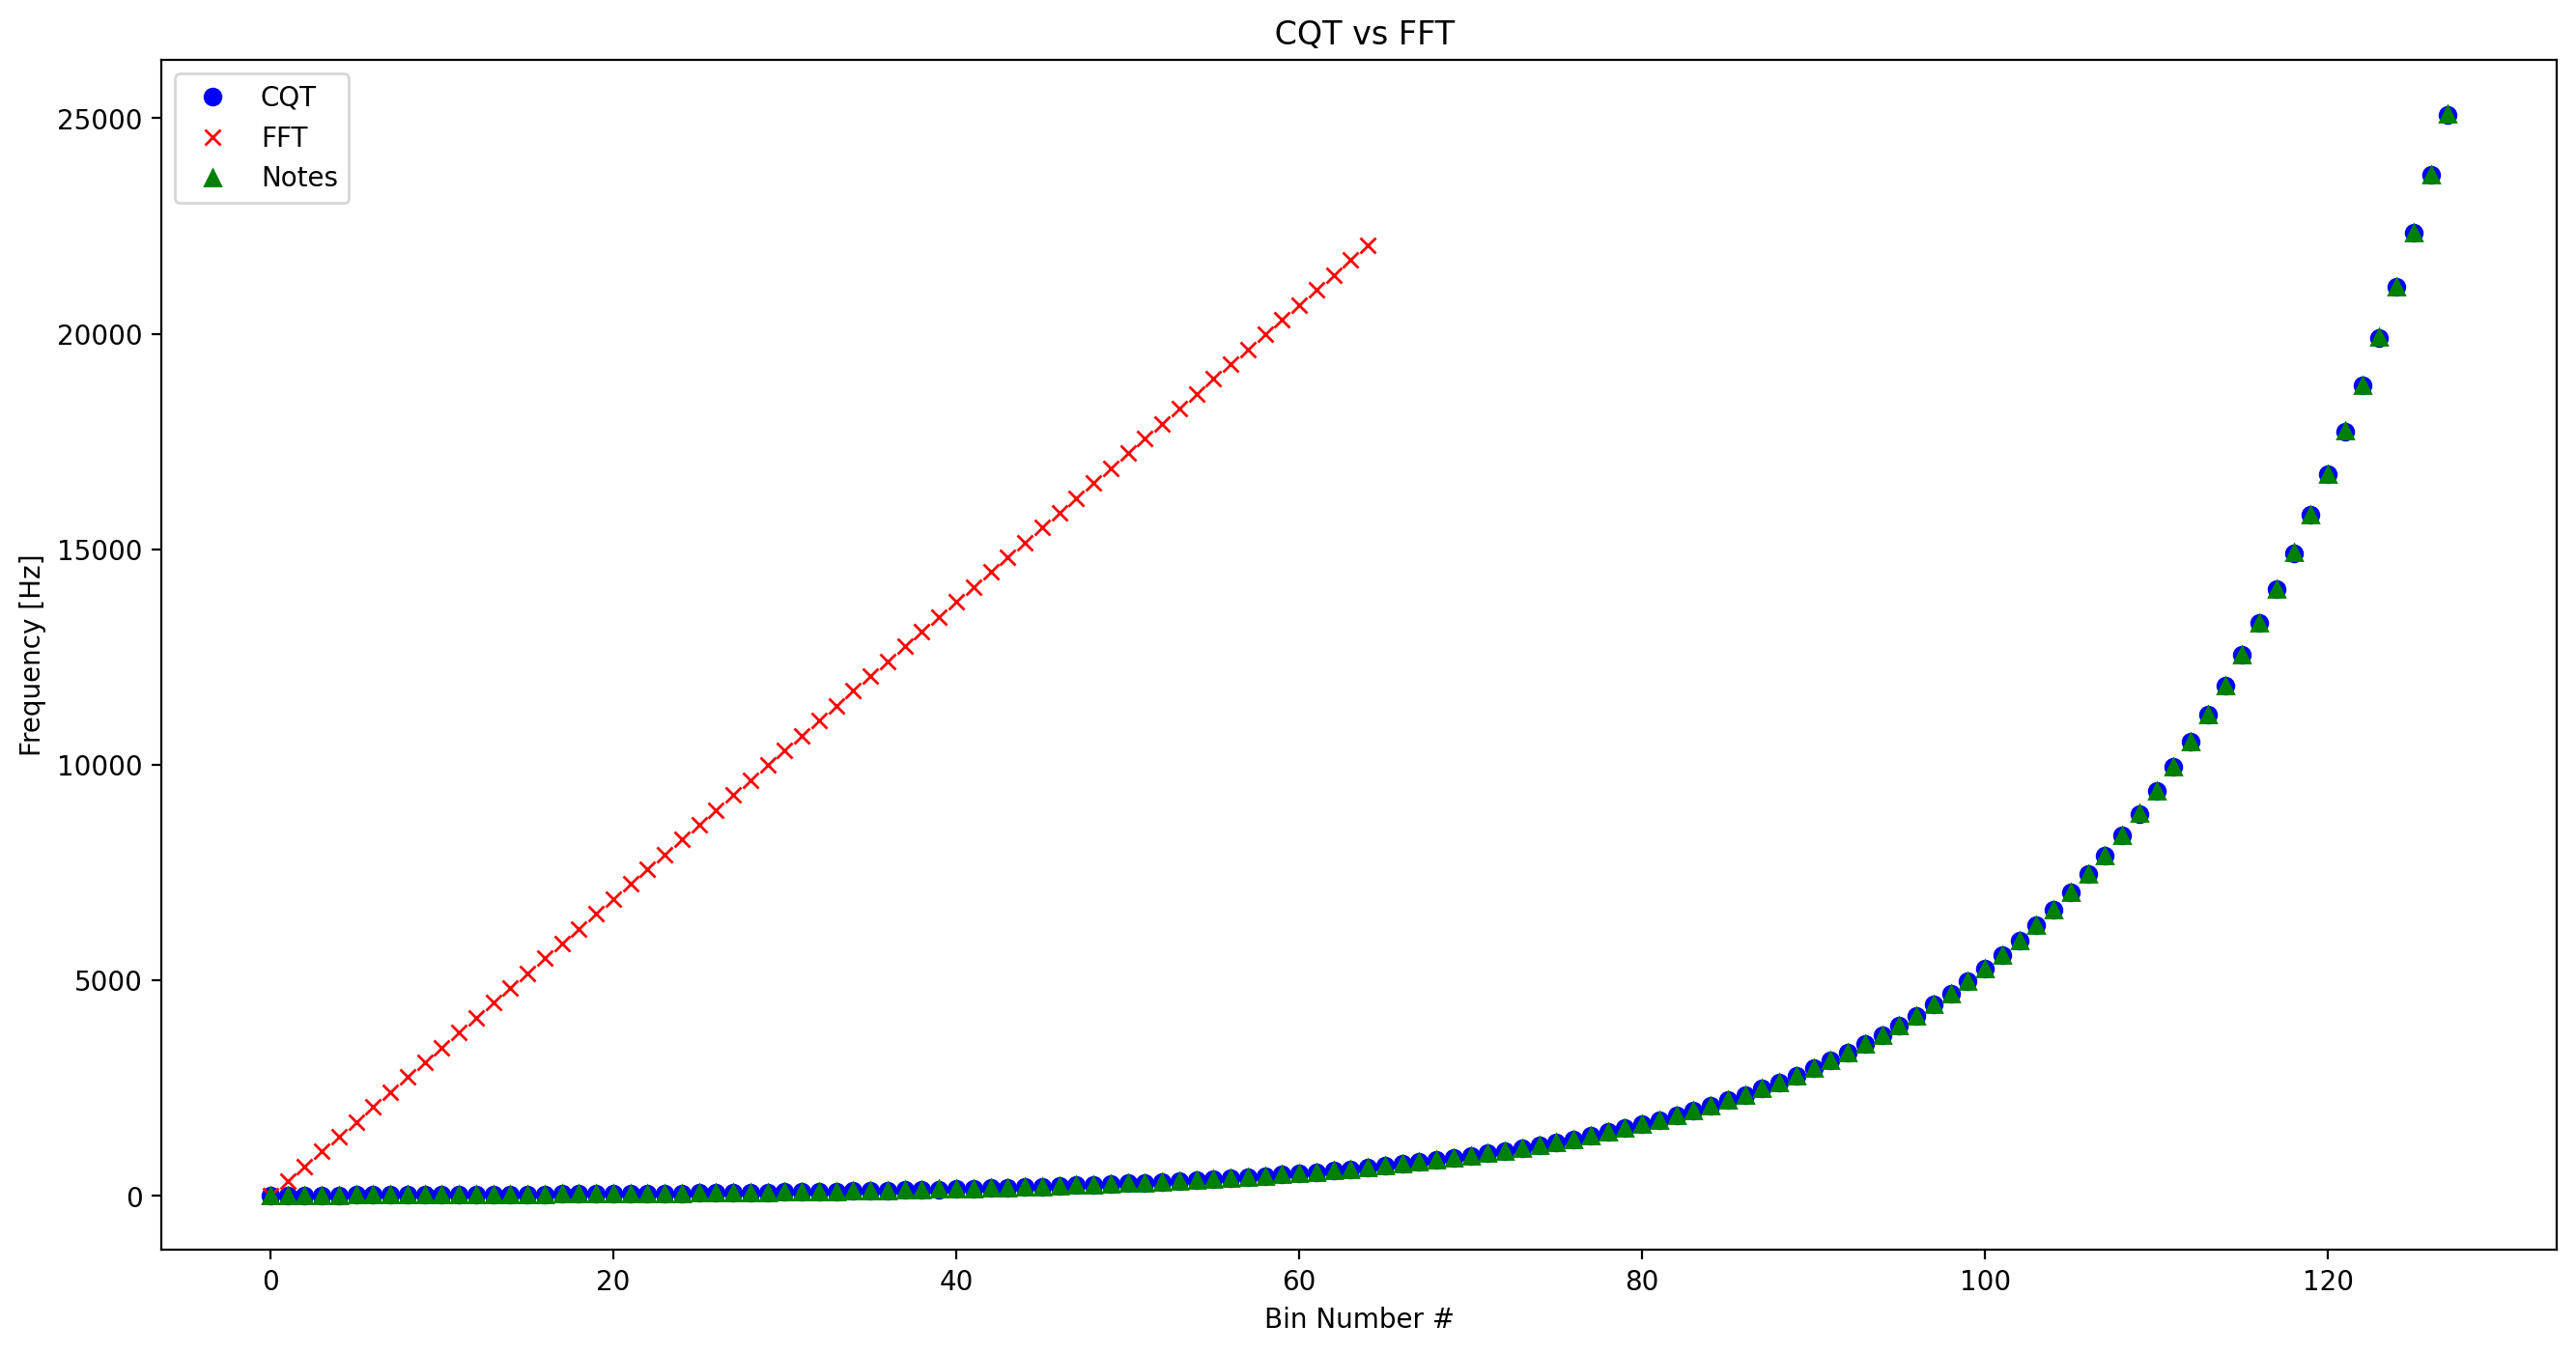

In [35]:
plt.figure()
plt.plot(cqt_freqs, 'bo', label='CQT')
plt.plot(fft_freqs, 'rx', label= 'FFT')
plt.plot(notes_freqs, 'g^', label = 'Notes')
plt.title(" CQT vs FFT")
plt.xlabel('Bin Number #')
plt.ylabel('Frequency [Hz]')
plt.legend();

## **Short-Time Fourier Transform (STFT)**

The Short-Time Fourier Transform (STFT) is a technique used to analyze non-stationary signals by breaking them into short time segments and applying the Fourier Transform to each segment.

### **Key Features:**
- **Time-Frequency Representation:** Provides a 2D representation of a signal, showing how its frequency content evolves over time.
- **Windowing:** A sliding window is applied to isolate segments of the signal for analysis.
- **Trade-Off:** There is a trade-off between time and frequency resolution, determined by the window size.

### **Applications:**
- Speech processing
- Music analysis
- Biomedical signal analysis (e.g., EEG, ECG)

---

### **Advantages:**
- Captures time-varying frequency information.
- Suitable for signals that change over time.

### **Limitations:**
- Fixed resolution throughout the signal.
- Choice of window size can impact the quality of the analysis (narrow window = better time resolution, wide window = better frequency resolution).

---

### **Comparison with FFT:**
- **FFT**: Analyzes the entire signal as a whole in the frequency domain.
- **STFT**: Analyzes small time segments, providing a time-localized frequency representation.

The STFT is a powerful tool for understanding dynamic signals but involves balancing precision in time and frequency domains.


In [36]:
import numpy as np

def custom_stft(signal, fs, window_size, hop_size):
    """
    Compute the Short-Time Fourier Transform (STFT) of an audio signal.
    
    Args:
        signal (np.ndarray): Input audio signal (1D).
        fs (int): Sampling rate of the audio signal.
        window_size (int): Size of the FFT window.
        hop_size (int): Step size between successive windows.
        
    Returns:
        times (np.ndarray): Time values corresponding to each frame.
        frequencies (np.ndarray): Frequency values corresponding to each FFT bin.
        stft_matrix (np.ndarray): Complex STFT matrix (shape: [num_frequencies, num_frames]).
    """
    # Create a Hamming window
    window = np.hamming(window_size)
    
    # Number of frames
    num_frames = 1 + (len(signal) - window_size) // hop_size
    stft_matrix = np.zeros((window_size // 2 + 1, num_frames), dtype=complex)
    
    # Apply window and compute FFT for each frame
    for i in range(num_frames):
        start_idx = i * hop_size
        frame = signal[start_idx:start_idx + window_size]
        frame_windowed = frame * window
        fft_frame = np.fft.rfft(frame_windowed)  # Compute FFT (real-valued for efficiency)
        stft_matrix[:, i] = fft_frame

    # Compute time and frequency axes
    times = np.arange(num_frames) * hop_size / fs
    frequencies = np.fft.rfftfreq(window_size, d=1/fs)
    
    return times, frequencies, stft_matrix


## Parameters

In [37]:
window_size = 2048        # FFT window size
overlap = 0.5             # Overlap percentage
hop_size = int(window_size * (1 - overlap))

# Ensure the input signal is 1D
if len(x.shape) > 1:
    x = x[:, 0]  # Convert to mono by taking one channel

# Perform custom STFT
times, frequencies, stft_matrix = custom_stft(x, fs, window_size, hop_size)

# Compute magnitude (power spectrum)
magnitude = np.abs(stft_matrix)
magnitude_db = 20 * np.log10(np.maximum(magnitude, 1e-10))  # Convert to dB scale

# Print results
print("STFT Matrix Shape:", stft_matrix.shape)
print("Frequencies Shape:", frequencies.shape)
print("Times Shape:", times.shape)

STFT Matrix Shape: (1025, 186)
Frequencies Shape: (1025,)
Times Shape: (186,)


## **Onset Detection Using Energy Peaks**

This code snippet demonstrates a method to detect **onsets** (sudden changes or peaks in energy, often corresponding to the start of musical notes or beats) from an energy curve derived from audio data.

---

In [38]:
from scipy.ndimage import maximum_filter

# Calculate energy
energy = np.sum(magnitude ** 2, axis=0)

# Detect peaks in the energy curve
pre_post_max = 6  # Tune for peak detection
onset_frames = maximum_filter(energy, size=pre_post_max, mode='constant') == energy
onsets = times[onset_frames]

print("Detected Onsets (seconds):", onsets)

Detected Onsets (seconds): [ 0.     0.448  0.896  1.344  1.984  2.304  2.752  3.264  3.776  4.224
  4.416  4.672  5.12   5.76   6.528  6.976  7.488  7.68   8.     8.192
  8.704  8.896  9.344  9.6    9.856 10.112 10.56  10.816 11.264 11.456
 11.84 ]


## **Pitch Estimation Using Autocorrelation**

This function estimates the **pitch** (fundamental frequency) of a given audio signal using the **autocorrelation method**. The autocorrelation method is commonly used in pitch detection tasks, particularly in speech and music processing.

---

In [39]:
import numpy as np

def autocorrelation_pitch_estimation(signal, fs, min_freq=50, max_freq=2000):
    """
    Estimate pitch using the autocorrelation method.
    
    Args:
        signal (np.ndarray): Input audio signal (1D).
        fs (int): Sampling rate of the signal.
        min_freq (float): Minimum frequency to consider (Hz).
        max_freq (float): Maximum frequency to consider (Hz).
    
    Returns:
        pitch (float): Estimated pitch in Hz. Returns 0 if no pitch is found.
    """
    # Define the range of lags (in samples) for pitch detection
    min_lag = int(fs / max_freq)
    max_lag = int(fs / min_freq)
    
    # Compute the autocorrelation of the signal
    corr = np.correlate(signal, signal, mode="full")
    corr = corr[len(corr) // 2:]  # Use only the positive lags

    # Ignore the zero-lag peak
    corr[:min_lag] = 0

    # Find the lag corresponding to the maximum correlation
    lag = np.argmax(corr[min_lag:max_lag]) + min_lag

    # Convert lag to frequency (Hz)
    pitch = fs / lag if lag > 0 else 0
    return pitch


## **Frame-Based Pitch Detection Using Autocorrelation**

The function `frame_based_pitch_detection` estimates the **pitch** (fundamental frequency) of an audio signal by applying the autocorrelation pitch estimation method to each frame of the signal. This approach is particularly useful for analyzing signals that change over time, such as speech or music.

---

In [40]:
def frame_based_pitch_detection(signal, fs, frame_size, hop_size, min_freq=50, max_freq=2000):
    """
    Estimate pitch for each frame of the signal using the autocorrelation method.
    
    Args:
        signal (np.ndarray): Input audio signal (1D).
        fs (int): Sampling rate of the signal.
        frame_size (int): Size of each frame (in samples).
        hop_size (int): Step size between successive frames (in samples).
        min_freq (float): Minimum frequency to consider (Hz).
        max_freq (float): Maximum frequency to consider (Hz).
    
    Returns:
        pitches (list): List of estimated pitches (Hz) for each frame.
    """
    num_frames = 1 + (len(signal) - frame_size) // hop_size
    pitches = []

    for i in range(num_frames):
        # Extract the current frame
        start_idx = i * hop_size
        frame = signal[start_idx:start_idx + frame_size]

        # Apply pitch estimation
        pitch = autocorrelation_pitch_estimation(frame, fs, min_freq, max_freq)
        pitches.append(pitch)

    return pitches

## **Pitch Estimation Over Time**

**Pitch estimation over time** refers to the process of tracking the fundamental frequency (pitch) of an audio signal as it evolves over time. This is a crucial task in various audio analysis applications, including **speech processing**, **music analysis**, and **audio feature extraction**. The goal is to extract the pitch at every point in time (or over a defined period) to study how the frequency content changes.

---

### **Methods for Pitch Estimation:**

1. **Autocorrelation Method:**
   - The **autocorrelation** method is one of the most commonly used techniques for pitch detection. It computes the similarity of a signal with itself at various lags (delays), helping to identify periodicity and thus the fundamental frequency.
   - **Key Feature**: It is sensitive to periodic signals and is often used for pitch tracking in speech or monophonic music.

2. **Short-Time Fourier Transform (STFT):**
   - The **STFT** splits the signal into small overlapping frames and computes the Fourier Transform for each frame. By analyzing the frequency spectrum in each frame, we can estimate the pitch.
   - **Key Feature**: Provides a time-frequency representation, which can reveal both the temporal and spectral evolution of the signal.

3. **Harmonic Product Spectrum (HPS):**
   - The **Harmonic Product Spectrum** is a method that focuses on detecting harmonics of the signal. It multiplies the signal's spectrum with downsampled versions of itself to enhance harmonic peaks, making pitch detection more robust.
   - **Key Feature**: Particularly useful for detecting the pitch of harmonic signals (such as music or speech).

4. **Cepstral Methods:**
   - **Cepstral analysis** involves transforming the signal into the cepstral domain, where the pitch-related components become more distinguishable from other sound features.
   - **Key Feature**: Can be robust in noisy environments and is often used in speech processing.

---

### **Applications of Pitch Estimation Over Time:**

- **Speech Processing:**
   - **Prosody Analysis**: Detecting variations in pitch to understand the intonation, stress, and rhythm in speech.
   - **Voice Activity Detection**: Estimating pitch over time to differentiate between speech and non-speech segments.
   - **Speaker Identification**: Using pitch patterns to identify individual speakers.
   
- **Music Analysis:**
   - **Melody Detection**: Estimating the pitch of each note in a piece of music.
   - **Chord Recognition**: Detecting changes in pitch patterns to identify chord progressions in music.
   - **Tuning and Transposition**: Comparing the detected pitch with the expected pitch for tuning musical instruments or analyzing transposed melodies.

- **Bioacoustic Monitoring:**
   - Detecting pitch over time in animal vocalizations, such as bird songs or bat calls, to study behavior or species identification.

---

### **Challenges in Pitch Estimation Over Time:**

1. **Non-Stationary Signals**: Many real-world audio signals (e.g., speech or music) are highly non-stationary, meaning their characteristics change over time. This can make pitch estimation more difficult, particularly for rapidly changing sounds.

2. **Noise and Artifacts**: Noise or distortions in the signal (e.g., background noise or reverberation) can interfere with pitch detection. Advanced techniques such as harmonic analysis or filtering are often required to mitigate this issue.

3. **Temporal Resolution vs. Frequency Resolution**: There is a trade-off between temporal and frequency resolution in pitch estimation. Using shorter frames or hop sizes can improve the temporal resolution, but at the cost of frequency resolution (and vice versa).

4. **Complex Signals**: For polyphonic music or other complex sounds with multiple simultaneous frequencies, estimating the pitch of each individual component becomes challenging. Techniques like **source separation** or **harmonic analysis** are often necessary.

---

### **Common Tools for Pitch Estimation Over Time:**

- **Librosa**: A Python library for audio and music analysis that includes functions for pitch tracking and visualization.
- **Pyaudio**: A Python interface for real-time audio processing, often used for pitch estimation in live applications.
- **MATLAB**: Widely used in research for pitch estimation algorithms, offering a variety of built-in functions and toolboxes.

---

### **Conclusion:**

Pitch estimation over time is a fundamental task in audio signal processing, with applications ranging from speech recognition to music analysis. The choice of method depends on the characteristics of the audio signal and the specific requirements of the task. Techniques such as autocorrelation, STFT, and harmonic analysis provide powerful tools for tracking the pitch of both stationary and dynamic signals.


Estimated Pitches (Hz): [2000.0, 2000.0, 2000.0, 2000.0, 2000.0, 410.2564102564103, 280.70175438596493, 139.1304347826087, 139.1304347826087, 275.86206896551727, 275.86206896551727, 275.86206896551727, 139.1304347826087, 139.1304347826087, 139.1304347826087, 139.1304347826087, 421.05263157894734, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.09302325581393, 421.05263157894734, 421.05263157894734, 421.05263157894734, 139.1304347826087, 140.35087719298247, 695.6521739130435, 695.6521739130435, 139.1304347826087, 421.05263157894734, 421.05263157894734, 139.1304347826087, 139.1304347826087, 139.1304347826087, 139.1304347826087, 275.86206896551727, 275.86206896551727, 139.1304347826087, 139.1304347826087, 139.1304347826087, 421.05263157894734, 421.05263157894734, 421.05263157894734, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.09302325581393, 372.093023255

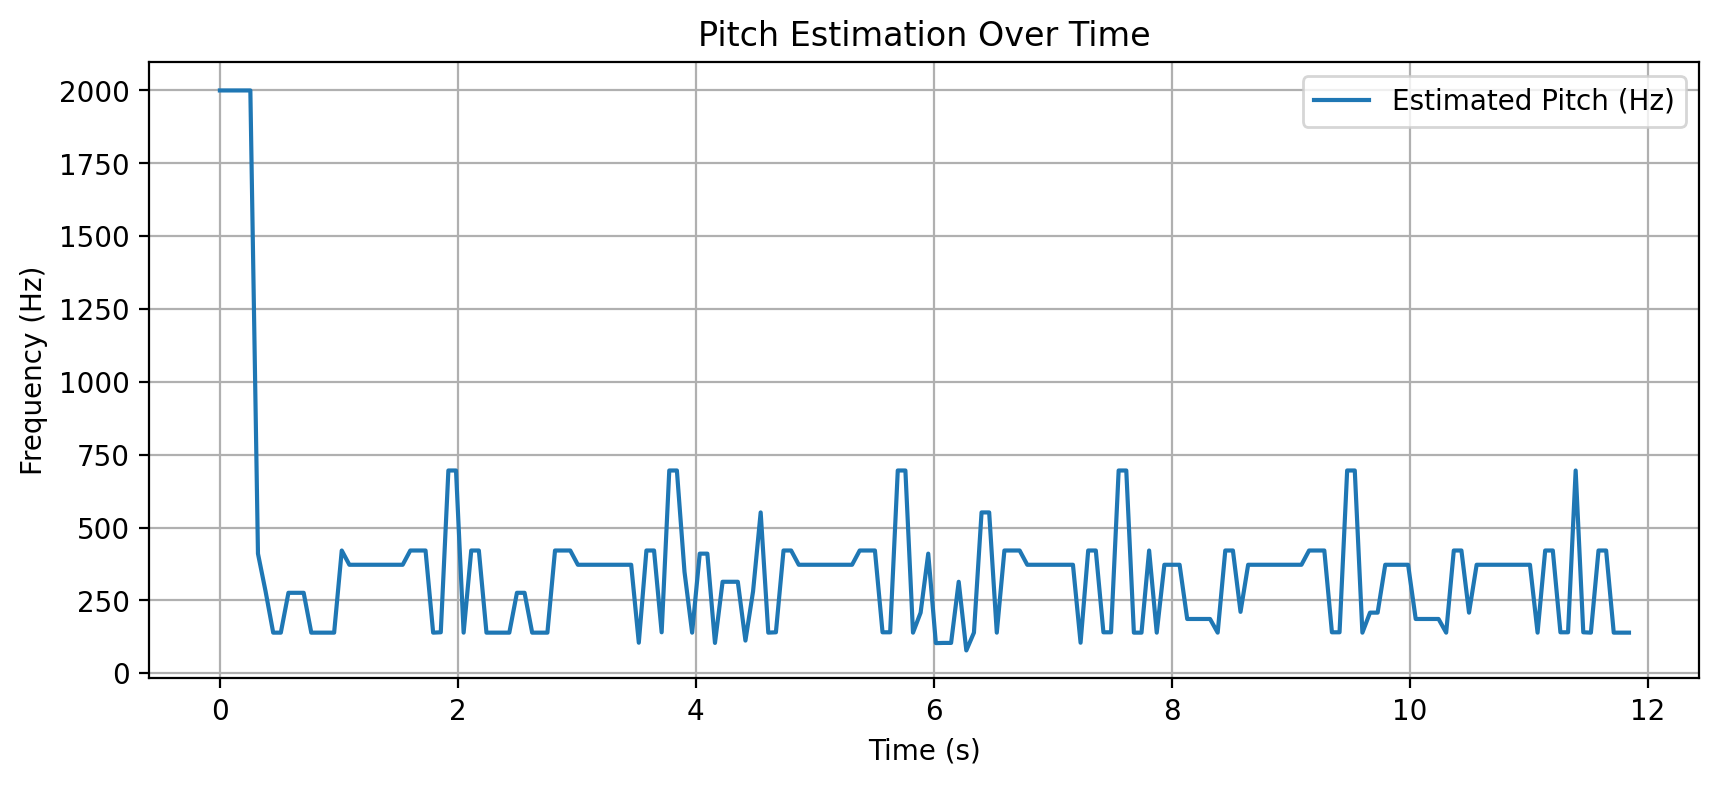

In [41]:
# Parameters
frame_size = 2048            # Size of each frame
hop_size = frame_size // 2   # 50% overlap

# Apply frame-based pitch detection
pitches = frame_based_pitch_detection(x, fs, frame_size, hop_size, min_freq=50, max_freq=2000)

# Convert to time axis for visualization
time_axis = np.arange(len(pitches)) * hop_size / fs

# Print results
print("Estimated Pitches (Hz):", pitches)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(time_axis, pitches, label="Estimated Pitch (Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Estimation Over Time")
plt.grid()
plt.legend()
plt.show()


## **Onset Envelope and Detected Onsets**

**Onset detection** refers to the task of identifying the start points of musical events, such as beats or note onsets, in an audio signal. **Onset envelope** is a time-domain representation that highlights the rapid changes in signal energy, which correspond to musical onsets. By analyzing this envelope, we can detect when these events occur.

---

### **Onset Envelope:**

The **onset envelope** is a time-varying curve that emphasizes the intensity of abrupt changes in the signal, typically corresponding to the start of a musical note or sound event. This envelope is often derived from the audio signal by extracting features such as energy, spectral flux, or other forms of instantaneous intensity.

#### **Key Steps in Onset Envelope Creation:**

1. **Compute the Signal Energy:**
   - The energy at each time frame is computed by summing the squared magnitudes of the signal (or its spectrogram) over a window.
   - **Formula**: `Energy(t) = sum(|x(t, f)|^2)` where `x(t, f)` is the signal magnitude at time `t` and frequency `f`.

2. **Compute Temporal Features:**
   - **Spectral Flux**: Measures how much the signal's frequency content changes between consecutive frames. This can be calculated by comparing the magnitude spectra of consecutive frames.
   - **Derivative of Energy**: The rate of change in the energy or spectral features can highlight the onset events.
   
3. **Smoothing the Envelope:**
   - Smoothing or filtering the energy curve can help reduce noise, making the onset detection more robust. This step might involve using techniques like low-pass filtering or applying moving averages.

4. **Onset Envelope Extraction:**
   - The result is a smooth envelope that tracks the intensity of the audio signal over time, where peaks in this envelope correspond to sudden changes in the signal (such as the start of a musical note).

---

### **Detected Onsets:**

Once we have the **onset envelope**, we can detect the **onsets** themselves, which are the specific points in time where significant changes in signal energy or spectral features occur.

#### **Key Steps in Onset Detection:**

1. **Peak Detection:**
   - Onsets are detected by finding local maxima in the onset envelope. These peaks correspond to moments when the signal undergoes a rapid change, such as the attack of a musical note.
   - **Algorithm**: A maximum filter or thresholding technique can be used to identify these peaks.

2. **Thresholding:**
   - A **threshold** can be applied to the onset envelope to eliminate smaller peaks that are likely to be noise or irrelevant. Only those peaks exceeding a certain threshold are considered valid onsets.

3. **Temporal Refinement:**
   - Detected onsets can be refined by considering the duration of the peaks or comparing with prior and subsequent frames to ensure they represent actual onsets.

4. **Onset Locations:**
   - The detected onsets correspond to the times in the audio where musical events (such as note starts or beats) are likely to occur.


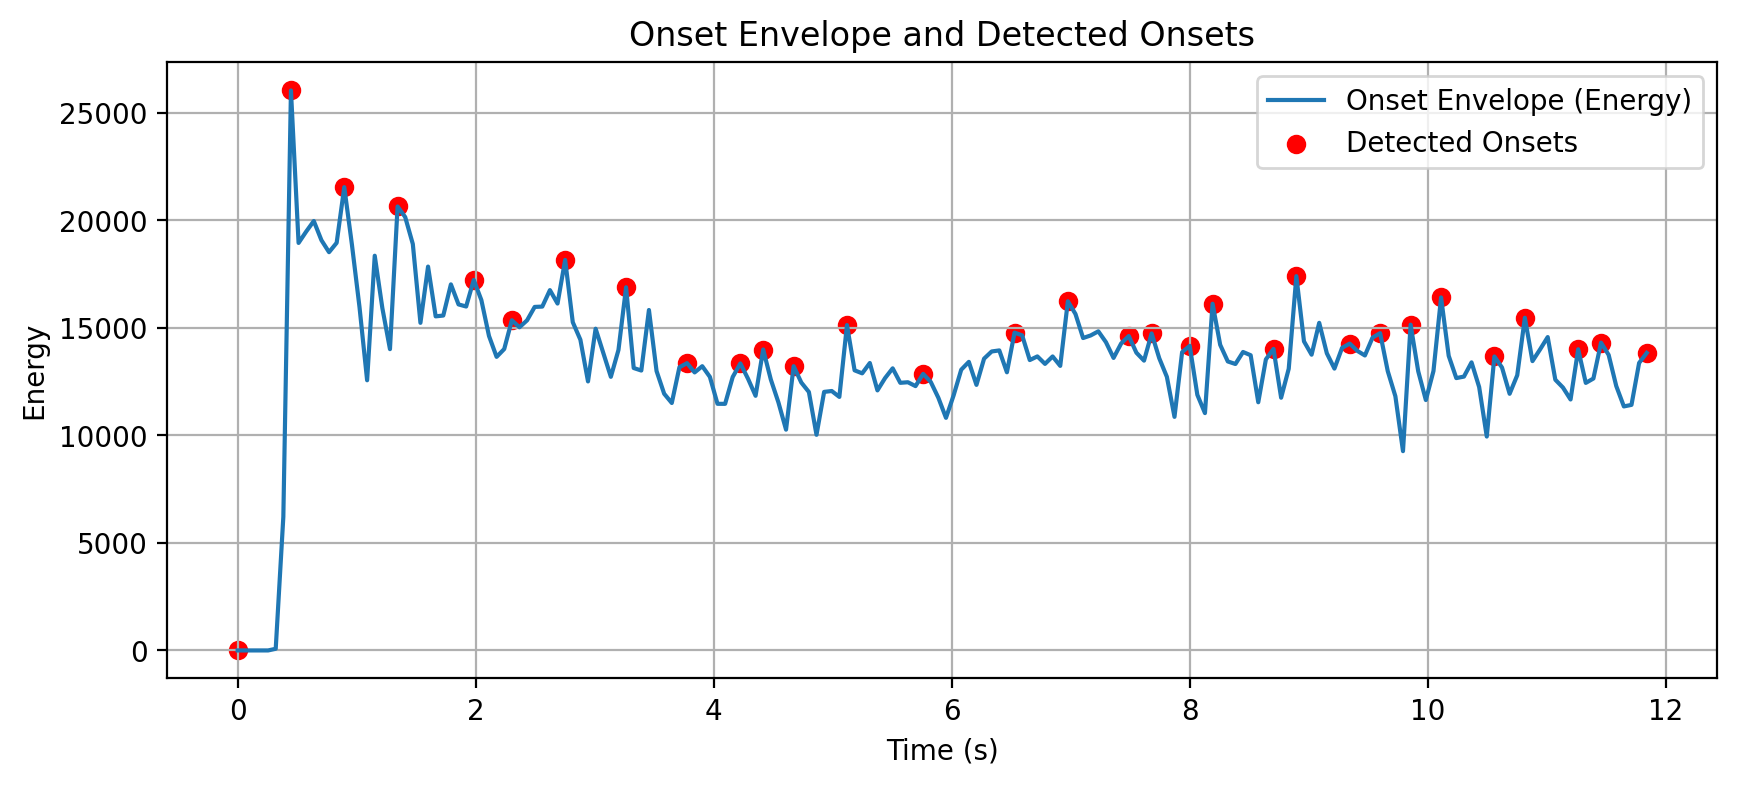

In [42]:
import matplotlib.pyplot as plt

# Visualize onset envelope (energy curve)
plt.figure(figsize=(10, 4))
plt.plot(times, energy, label="Onset Envelope (Energy)")
plt.scatter(onsets, [energy[np.argmin(abs(times - t))] for t in onsets], color='red', label="Detected Onsets")
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.legend()
plt.title("Onset Envelope and Detected Onsets")
plt.grid()
plt.show()


In [43]:
# Refine onset detection by setting a minimum threshold
min_energy_threshold = 0.1 * max(energy)  # Tune threshold
refined_onsets = [t for t in onsets if energy[np.argmin(abs(times - t))] > min_energy_threshold]

print("Refined Onsets (seconds):", refined_onsets)

Refined Onsets (seconds): [0.448, 0.896, 1.344, 1.984, 2.304, 2.752, 3.264, 3.776, 4.224, 4.416, 4.672, 5.12, 5.76, 6.528, 6.976, 7.488, 7.68, 8.0, 8.192, 8.704, 8.896, 9.344, 9.6, 9.856, 10.112, 10.56, 10.816, 11.264, 11.456, 11.84]


## **MIDI (Musical Instrument Digital Interface)**

**MIDI** (Musical Instrument Digital Interface) is a standard communication protocol used to connect electronic musical instruments, computers, and other audio devices. It allows for the exchange of musical information in the form of messages, which represent musical events such as note on/off, pitch, velocity, and control changes.

---

### **Key Features of MIDI:**

1. **Message-Based Communication:**
   - MIDI transmits information through a series of **messages**. Each message is made up of one or more bytes and conveys specific musical information. For example, a **Note On** message includes the note's pitch and velocity (how hard the note is played).

2. **Channel-Based System:**
   - MIDI is based on 16 **channels**, each of which can carry a different instrument or part. Each channel can represent a different sound source, allowing multiple instruments to be played simultaneously on different tracks.

3. **Control Changes:**
   - MIDI messages include **control change** messages that allow for adjustments in various parameters such as volume, modulation, expression, and sustain pedal.

4. **Standardized Notation:**
   - MIDI messages are defined in a way that is independent of the actual sound generation. This allows MIDI to be used with different instruments or software, ensuring compatibility across a wide range of devices.

---

### **MIDI Message Types:**

1. **Note On / Note Off:**
   - **Note On**: This message signals the start of a note, including the pitch (note number) and velocity (the intensity of the note).
   - **Note Off**: This message signals the end of a note, and can also include velocity, which often represents how the note is released.

   Example:
   - **Note On**: `0x90` (Channel 1) + Note number (e.g., 60 for Middle C) + Velocity (e.g., 127 for maximum intensity)
   - **Note Off**: `0x80` (Channel 1) + Note number + Velocity

2. **Control Change:**
   - Control changes are used to modify the behavior of an instrument, such as adjusting volume, pitch bend, or modulation. Each control change message includes the control number (e.g., for modulation or volume) and the value.

   Example:
   - **Modulation Wheel**: Control number `1` (modulation wheel) + Value (e.g., `64` for halfway modulation).
   
3. **Program Change:**
   - This message allows the selection of a new sound or instrument. It typically includes the program number that corresponds to a sound preset.

   Example:
   - **Program Change**: `0xC0` (Channel 1) + Program number (e.g., `5` for a particular instrument sound).

4. **Pitch Bend:**
   - This message allows the pitch of a note to be bent up or down. It includes a value that represents the amount of pitch change.

---

### **Applications of MIDI:**

1. **Music Production:**
   - **Sequencing**: MIDI is widely used in digital audio workstations (DAWs) to create and arrange music by sequencing note events on tracks.
   - **Virtual Instruments**: MIDI is used to control software synthesizers or samplers, enabling the generation of sounds without physical instruments.
   - **Performance**: Musicians use MIDI to control hardware synthesizers, drum machines, and other MIDI-compatible devices during live performances.

2. **Composition and Arrangement:**
   - Composers use MIDI to write and arrange music digitally. MIDI allows precise control over timing, pitch, and expression without having to record actual audio.

3. **Music Transcription:**
   - MIDI data can be used to transcribe music into sheet music, as the note-on and note-off events contain enough information to recreate the musical score.

4. **Film Scoring and Audio Engineering:**
   - In film scoring, MIDI is used to create orchestral mock-ups, allowing composers to compose and edit music for films or games before final recording.

5. **Game Audio:**
   - MIDI is used for creating adaptive and interactive soundtracks in video games, where the music can dynamically change based on game events.

---

### **Advantages of MIDI:**

1. **File Size Efficiency:**
   - Since MIDI represents musical events in a compact digital form (as numerical messages), it requires far less storage space than audio files. This makes it easy to store and share music data.

2. **Flexibility and Control:**
   - MIDI allows for easy manipulation of music, including changing tempo, key, or instruments, all without needing to re-record or re-arrange the music.

3. **Interoperability:**
   - MIDI is supported by almost all electronic musical instruments, computers, and music production software, ensuring broad compatibility across different platforms.

4. **Real-Time Communication:**
   - MIDI allows for real-time communication between devices. This enables live performances, real-time adjustments to sound, and interactive music creation.

---

### **MIDI File Format:**

MIDI files typically come in two formats:
1. **Standard MIDI File (SMF)**: The most common file format for storing MIDI sequences. SMF contains tracks that are organized by events and timestamps.
   - **Type 0**: All tracks are merged into one.
   - **Type 1**: Multiple tracks for different parts or instruments, often used in multi-track compositions.
   
2. **MIDI System Exclusive (Sysex):**
   - Sysex messages allow devices to exchange non-standard messages, enabling manufacturers to create custom control over their MIDI devices.

---

### **Challenges with MIDI:**

1. **No Audio Content:**
   - MIDI does not contain audio itself. It only represents the instructions needed to produce sounds. The quality of the sound depends on the synthesizer or sampler used to interpret the MIDI data.

2. **Limited Expressiveness:**
   - While MIDI allows control over many aspects of sound (e.g., velocity, modulation), it lacks the nuanced expression of actual human performance (such as vibrato or timing irregularities) unless specifically programmed.

3. **Complexity in Real-Time Performance:**
   - For polyphonic music or complex pieces, real-time manipulation of multiple MIDI channels can become challenging and difficult to synchronize perfectly.

---

### **Conclusion:**

MIDI is a powerful, standardized communication protocol that has revolutionized music production, performance, and distribution. By encoding musical events as digital messages, MIDI allows for flexible, efficient, and interoperable communication between instruments, software, and hardware. Despite its limitations, such as the absence of audio content, MIDI remains the backbone of modern music technology, offering vast potential for musicians, producers, and sound designers.


In [44]:
import numpy as np
hop_length = 1024
# Match pitch to the nearest onset
pitch_times = np.linspace(0, len(pitches) * hop_length / fs, len(pitches))
note_onsets = []
note_pitches = []

for onset in refined_onsets:
    idx = np.argmin(abs(pitch_times - onset))
    note_onsets.append(onset)
    note_pitches.append(pitches[idx])

# Convert pitch (Hz) to MIDI note numbers
def hz_to_midi(hz):
    return 69 + 12 * np.log2(hz / 440.0) if hz > 0 else 0

midi_notes = [hz_to_midi(p) for p in note_pitches]
print("MIDI Notes:", midi_notes)


MIDI Notes: [49.06721424231662, 49.06721424231662, 66.09791779722396, 76.93035138096498, 49.06721424231662, 49.06721424231662, 66.09791779722396, 76.93035138096498, 63.14399074999118, 45.294638812308456, 49.21841468367223, 66.09791779722396, 76.93035138096498, 72.91732291211827, 66.09791779722396, 49.21841468367223, 76.93035138096498, 66.09791779722396, 54.09791779722396, 66.09791779722396, 66.09791779722396, 68.2379646923261, 76.93035138096498, 66.09791779722396, 54.09791779722396, 56.011656365310316, 66.09791779722396, 68.2379646923261, 76.93035138096498, 49.06721424231662]


In [45]:
from midiutil import MIDIFile

# Create a MIDI file
midi_file = MIDIFile(1)  # Single track
track = 0
time = 0  # Start at the beginning
channel = 0
volume = 100

# Add notes to MIDI file
midi_file.addTrackName(track, time, "Generated Track")
midi_file.addTempo(track, time, 120)  # Default tempo: 120 BPM

for onset, midi_note in zip(note_onsets, midi_notes):
    duration = 1  # Default duration for each note
    midi_file.addNote(track, channel, int(midi_note), onset, duration, volume)

# Write to file
output_file = "output.mid"
with open(output_file, "wb") as f:
    midi_file.writeFile(f)

print(f"MIDI file saved as {output_file}")


MIDI file saved as output.mid


In [46]:
import numpy as np
from music21 import stream, note

# Your given data
pitch_times = np.linspace(0, len(pitches) * hop_length / fs, len(pitches))
note_onsets = []
note_pitches = []

for onset in refined_onsets:
    idx = np.argmin(abs(pitch_times - onset))
    note_onsets.append(onset)
    note_pitches.append(pitches[idx])

# Convert pitch (Hz) to MIDI note numbers
def hz_to_midi(hz):
    return 69 + 12 * np.log2(hz / 440.0) if hz > 0 else 0

midi_notes = [hz_to_midi(p) for p in note_pitches]

# Generate music notation using music21
guitar_part = stream.Part()

for midi_note in midi_notes:
    if midi_note > 0:  # Only add notes with valid MIDI numbers
        music_note = note.Note(midi_note)
        music_note.quarterLength = 1  # Assign a default duration
        guitar_part.append(music_note)

# Show the generated music notation in text format
guitar_part.show('text')  # Display in text format


{0.0} <music21.note.Note C#>
{1.0} <music21.note.Note C#>
{2.0} <music21.note.Note F#>
{3.0} <music21.note.Note F>
{4.0} <music21.note.Note C#>
{5.0} <music21.note.Note C#>
{6.0} <music21.note.Note F#>
{7.0} <music21.note.Note F>
{8.0} <music21.note.Note E->
{9.0} <music21.note.Note A~>
{10.0} <music21.note.Note C#>
{11.0} <music21.note.Note F#>
{12.0} <music21.note.Note F>
{13.0} <music21.note.Note C#>
{14.0} <music21.note.Note F#>
{15.0} <music21.note.Note C#>
{16.0} <music21.note.Note F>
{17.0} <music21.note.Note F#>
{18.0} <music21.note.Note F#>
{19.0} <music21.note.Note F#>
{20.0} <music21.note.Note F#>
{21.0} <music21.note.Note G#>
{22.0} <music21.note.Note F>
{23.0} <music21.note.Note F#>
{24.0} <music21.note.Note F#>
{25.0} <music21.note.Note G#>
{26.0} <music21.note.Note F#>
{27.0} <music21.note.Note G#>
{28.0} <music21.note.Note F>
{29.0} <music21.note.Note C#>


# Self-Similarity Matrices (SSM)

## Introduction

Self-Similarity Matrices (SSMs) are a powerful tool for visualizing the repetitive structure of a signal, especially in the context of time-series analysis, audio processing, and music analysis. They are particularly useful for detecting patterns, periodicities, and similarities in a signal over time.

An SSM is a square matrix that represents the pairwise similarity between different segments (or frames) of a signal. It is commonly used to analyze time-series data by comparing each segment with every other segment in terms of some measure of similarity, often based on distance metrics.

In music and audio analysis, SSMs can be used to reveal recurring motifs, sections of music, or structural elements like chorus vs. verse in a song. In a more general sense, SSMs provide insights into the temporal self-similarity of a signal.

## Constructing a Self-Similarity Matrix

To create a self-similarity matrix, we follow these general steps:

1. **Divide the Signal into Overlapping Frames:**  
   The signal is split into small overlapping or non-overlapping segments (frames) of a fixed length. These segments are usually short to capture local characteristics of the signal.

2. **Compute the Similarity between Frames:**  
   For each pair of frames, we calculate a similarity measure, such as the Euclidean distance, cosine similarity, or correlation. The similarity score is stored in the matrix.

3. **Visualize the Matrix:**  
   The resulting matrix is typically symmetric (because similarity is mutual), and can be visualized as an image. This visualization can help identify patterns and structures in the signal.

### Example: Cosine Similarity-based SSM

One common measure for comparing frames is cosine similarity. For two frames, \( \mathbf{A} \) and \( \mathbf{B} \), the cosine similarity is calculated as:

\[
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
\]

Where \( \cdot \) represents the dot product of the vectors and \( \|\mathbf{A}\| \) is the norm (length) of vector \( \mathbf{A} \).

### Steps to Compute SSM

1. **Step 1: Preprocessing**  
   Preprocess the signal by dividing it into overlapping frames. For audio signals, this is typically done using the Short-Time Fourier Transform (STFT) or Mel-frequency cepstral coefficients (MFCCs).

2. **Step 2: Compute Similarity Matrix**  
   Calculate the pairwise similarity for each frame using cosine similarity, correlation, or another distance metric.

3. **Step 3: Visualize the Matrix**  
   The result is a symmetric matrix that shows how similar each frame is to every other frame. This matrix can be visualized using heatmaps or images to identify patterns in the signal.

## Applications of SSM

- **Music Analysis:**  
   In music, SSMs are used to identify repeating sections, such as choruses or verses, by comparing different parts of a song. They can also be used for genre classification, music transcription, and similarity-based retrieval.

- **Speech Analysis:**  
   In speech processing, SSMs can be used to study the repetition of phonetic patterns or syllabic structure over time.

- **Audio Segmentation:**  
   SSMs can segment an audio signal into parts with similar temporal patterns, which is useful for tasks such as event detection, audio segmentation, and classification.

- **Anomaly Detection:**  
   In non-music contexts, SSMs can be used to detect anomalous patterns in signals, such as detecting irregular behavior in time-series data from sensors or financial markets.



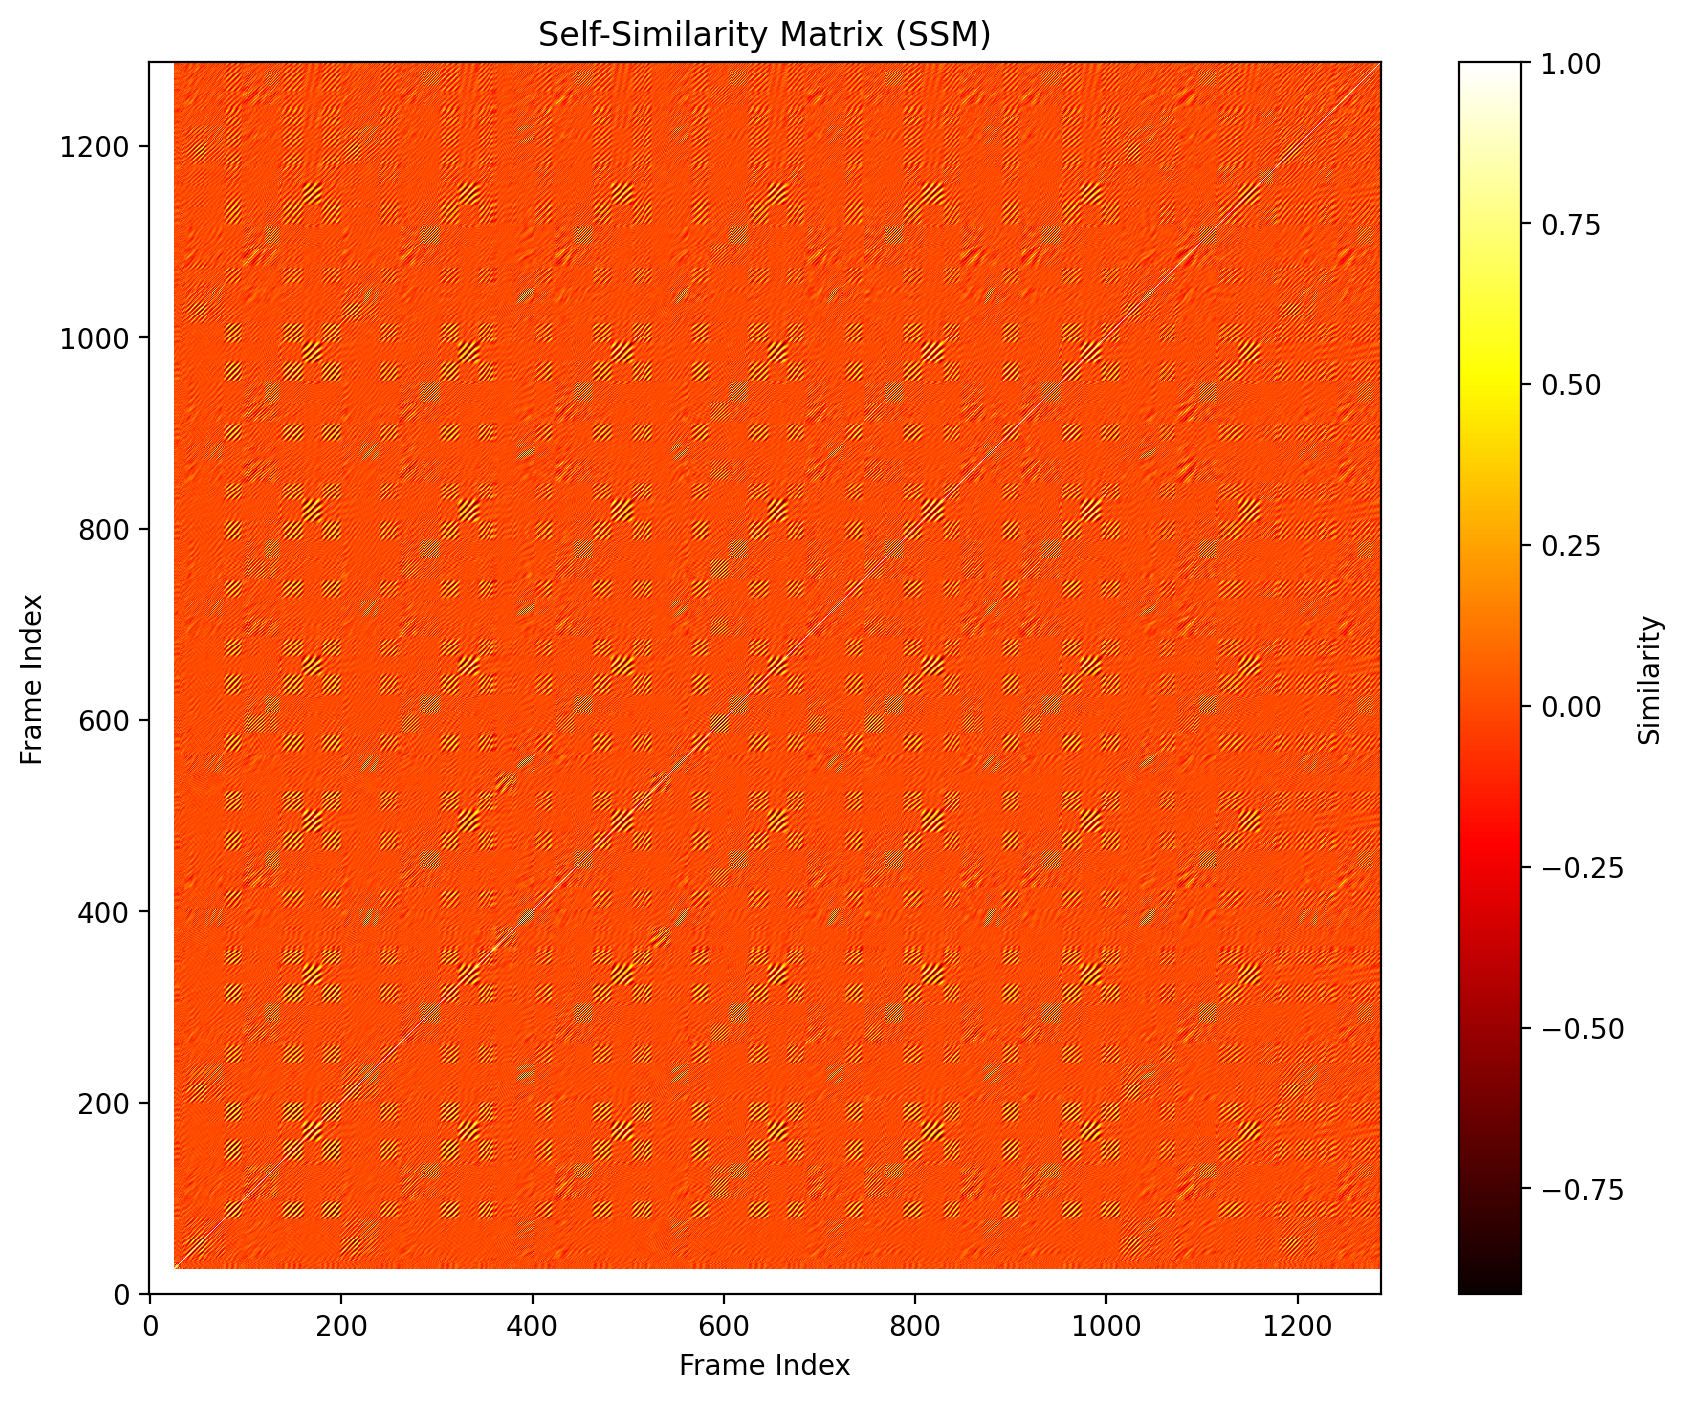

In [49]:
import numpy as np
from scipy.io import wavfile
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def compute_self_similarity_matrix(data, frame_size=2048, hop_size=512, metric='cosine'):
    """
    Compute a self-similarity matrix (SSM) for a time-series data.
    
    Parameters:
    - data (array-like): Input time-series data (e.g., audio waveform or feature vector).
    - frame_size (int): Size of each frame for analysis.
    - hop_size (int): Step size for overlapping frames.
    - metric (str): Similarity metric ('cosine', 'euclidean', etc.).
    
    Returns:
    - ssm (2D array): Self-similarity matrix.
    """
    # Frame segmentation
    num_frames = 1 + (len(data) - frame_size) // hop_size
    frames = np.array([data[i * hop_size : i * hop_size + frame_size] for i in range(num_frames)])
    
    # Normalize frames (important for cosine similarity)
    frames = frames / (np.linalg.norm(frames, axis=1, keepdims=True) + 1e-9)
    
    # Compute similarity matrix
    ssm = 1 - cdist(frames, frames, metric=metric)
    
    return ssm

# Load the WAV file
file_path = "./audio/Guns N Roses-Sweet Child O Mine Intro.wav"  # Replace with your file path
samplerate, data = wavfile.read(file_path)

# If stereo, convert to mono
if len(data.shape) > 1:
    data = data[:, 0]

# Compute the SSM
ssm = compute_self_similarity_matrix(data, frame_size=2048, hop_size=512, metric='cosine')

# Visualize the SSM
plt.figure(figsize=(10, 8))
plt.imshow(ssm, cmap='hot', interpolation='nearest', origin='lower')
plt.title("Self-Similarity Matrix (SSM)")
plt.xlabel("Frame Index")
plt.ylabel("Frame Index")
plt.colorbar(label='Similarity')
plt.show()


# Chord Generation and Harmonization: Template-Based Chord Recognition + Rule-Based Harmonization

## Introduction

In music transcription for guitar, detecting the harmonic structure of a piece is essential for understanding the underlying chords that define the piece's harmonic progression. This process can be divided into two main stages: **Chord Recognition** and **Harmonization**. 

1. **Template-Based Chord Recognition** is used to identify the chord being played by matching the detected harmonic patterns in the audio signal to a predefined set of chord templates.
2. **Rule-Based Harmonization** is applied to generate complementary harmonies that align with the recognized chord, ensuring a coherent musical structure that complements the original melody and rhythm.

This approach is particularly useful for guitar transcription, as it simplifies the process of identifying chords from guitar recordings, allowing for the generation of harmonically consistent accompaniments.

## Chord Generation: Template-Based Chord Recognition

### What is Template-Based Chord Recognition?

Template-Based Chord Recognition involves matching the detected pitch classes from an audio signal to a predefined set of chord templates. These templates represent common chord structures (major, minor, diminished, etc.) and include the specific note intervals that make up each chord.

For example:
- A **C Major** chord consists of the notes C, E, and G.
- A **C# Major** chord consists of C#, F, and G#.

The system uses the pitch classes derived from the audio signal (which can be obtained through techniques such as Short-Time Fourier Transform (STFT), FFT, or pitch class profile estimation) and compares them to the predefined chord templates. By calculating the similarity between the detected pitch classes and the templates, the most likely chord is identified.

### How It Works

1. **Pitch Class Detection:**  
   The audio signal is first processed to detect the pitch classes present in each frame of the signal. This is typically done using a frequency spectrum analysis (e.g., FFT or STFT).
   
2. **Template Matching:**  
   The detected pitch classes are compared to a set of chord templates. Each chord template is a binary vector representing the presence (1) or absence (0) of each pitch class in the chord. The system computes the similarity between the detected pitch classes and each template, selecting the chord with the highest similarity as the recognized chord.

Example chord templates:
- C Major: [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0] (C, E, G)
- D Minor: [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0] (D, F, A)

This approach allows for robust chord recognition even in noisy or complex musical contexts, as long as the harmonic patterns are present.


In [55]:
import numpy as np
from scipy.signal import find_peaks
from scipy.io import wavfile  # For reading .wav files
import librosa

# Define chord templates for recognition (same as in your original code)
CHORD_TEMPLATES = {
    # Major chords
    "C Major":    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],  # C-E-G
    "C# Major":   [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],  # C#-F-G#
    "D Major":    [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],  # D-F#-A
    "Eb Major":   [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],  # Eb-G-Bb
    "E Major":    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],  # E-G#-B
    "F Major":    [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],  # F-A-C
    "F# Major":   [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],  # F#-A#-C#
    "G Major":    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],  # G-B-D
    "Ab Major":   [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],  # Ab-C-Eb
    "A Major":    [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],  # A-C#-E
    "Bb Major":   [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],  # Bb-D-F
    "B Major":    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],  # B-D#-F#
    
    # Minor chords
    "C Minor":    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  # C-Eb-G
    "C# Minor":   [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],  # C#-E-G#
    "D Minor":    [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],  # D-F-A
    "Eb Minor":   [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],  # Eb-Gb-Bb
    "E Minor":    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],  # E-G-B
    "F Minor":    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],  # F-Ab-C
    "F# Minor":   [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],  # F#-A-C#
    "G Minor":    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],  # G-Bb-D
    "Ab Minor":   [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],  # Ab-Cb-Eb
    "A Minor":    [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],  # A-C-E
    "Bb Minor":   [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],  # Bb-Db-F
    "B Minor":    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],  # B-D-F#
}

def detect_pitch_classes(signal, samplerate, frame_size=2048, hop_size=1024):
    """
    Detect the pitch classes (C, C#, D, ..., B) present in the audio signal.
    Uses a basic frequency spectrum analysis.
    """
    # Apply a simple short-time Fourier transform
    num_frames = 1 + (len(signal) - frame_size) // hop_size
    pitch_classes = np.zeros(12)  # 12 pitch classes (C, C#, ..., B)

    for i in range(num_frames):
        frame = signal[i * hop_size : i * hop_size + frame_size]
        spectrum = np.abs(np.fft.rfft(frame))  # Magnitude spectrum
        freqs = np.fft.rfftfreq(frame_size, 1 / samplerate)

        # Find peaks in the spectrum (significant frequencies)
        peaks, _ = find_peaks(spectrum, height=np.max(spectrum) * 0.1)
        for freq in freqs[peaks]:
            if freq > 0:  # Map frequency to pitch class
                midi_note = int(np.round(12 * np.log2(freq / 440.0) + 69)) % 12
                pitch_classes[midi_note] += 1

    return pitch_classes / np.max(pitch_classes)  # Normalize

def recognize_chord(pitch_classes):
    """
    Match detected pitch classes to the closest chord template.
    """
    max_similarity = 0
    recognized_chord = None

    for chord, template in CHORD_TEMPLATES.items():
        similarity = np.dot(pitch_classes, template)
        if similarity > max_similarity:
            max_similarity = similarity
            recognized_chord = chord

    return recognized_chord

def harmonize_chord(chord, rules="basic"):
    """
    Apply rule-based harmonization to generate complementary harmonies.
    """
    harmonization_rules = {
    # Major chords
    "C Major":    ["C", "E", "G"],
    "C# Major":   ["C#", "F", "G#"],
    "D Major":    ["D", "F#", "A"],
    "Eb Major":   ["Eb", "G", "Bb"],
    "E Major":    ["E", "G#", "B"],
    "F Major":    ["F", "A", "C"],
    "F# Major":   ["F#", "A#", "C#"],
    "G Major":    ["G", "B", "D"],
    "Ab Major":   ["Ab", "C", "Eb"],
    "A Major":    ["A", "C#", "E"],
    "Bb Major":   ["Bb", "D", "F"],
    "B Major":    ["B", "D#", "F#"],
    
    # Minor chords
    "C Minor":    ["C", "Eb", "G"],
    "C# Minor":   ["C#", "E", "G#"],
    "D Minor":    ["D", "F", "A"],
    "Eb Minor":   ["Eb", "Gb", "Bb"],
    "E Minor":    ["E", "G", "B"],
    "F Minor":    ["F", "Ab", "C"],
    "F# Minor":   ["F#", "A", "C#"],
    "G Minor":    ["G", "Bb", "D"],
    "Ab Minor":   ["Ab", "Cb", "Eb"],
    "A Minor":    ["A", "C", "E"],
    "Bb Minor":   ["Bb", "Db", "F"],
    "B Minor":    ["B", "D", "F#"],
    }

    if rules == "basic" and chord in harmonization_rules:
        return harmonization_rules[chord]
    else:
        return ["Harmony rules not defined for", chord]

def process_wav_file(file_path):
    """
    Process the input .wav file, detect pitch classes, recognize chord, and harmonize it.
    """
    # Load the .wav file
    samplerate, signal = wavfile.read(file_path)

    # If the file has multiple channels (stereo), just take one channel (mono)
    if len(signal.shape) > 1:
        signal = signal[:, 0]  # Take the first channel (mono)

    # Normalize the signal
    signal = signal / np.max(np.abs(signal))

    # Step 1: Detect pitch classes
    pitch_classes = detect_pitch_classes(signal, samplerate)

    # Step 2: Recognize chord
    recognized_chord = recognize_chord(pitch_classes)
    print("Recognized Chord:", recognized_chord)

    # Step 3: Harmonize chord
    harmonies = harmonize_chord(recognized_chord)
    print("Harmonization:", harmonies)

# Example Usage
if __name__ == "__main__":
    # Replace 'your_audio_file.wav' with the actual path to your .wav file
    process_wav_file("./audio/Guns N Roses-Sweet Child O Mine Intro.wav")


Recognized Chord: C# Major
Harmonization: ['C#', 'F', 'G#']
